## Getting Started with pyDelta's _next_ branch

pyDelta's _next_ branch contains our work-in-progress implementation of experiments using Delta variants as a python library. We assume you have installed the library using `pip`.

First, let's import the delta package:

In [1]:
%load_ext autoreload
%autoreload 2
import delta
from dimcat.data import resources
from docs.notebooks import utils

### Loading the corpus and preparing the feature matrix

The [Corpus](delta.html#delta.corpus.Corpus) class represents the corpus as a bag-of-words feature matrix. In its simplest form, you can just call `Corpus` and pass it the directory your texts reside in:

In [2]:
describer = delta.TsvDocumentDescriber("../distant_listening_corpus.metadata.tsv")

In [3]:
sliced_notes = utils.get_sliced_notes()

In [4]:
prevalence_matrix: resources.PrevalenceMatrix = sliced_notes.apply_step(dict(
    dtype="PrevalenceAnalyzer",
    columns="chord_reduced_and_mode",
    index=["corpus", "piece"]
))

In [5]:
metadata = delta.Metadata(
        features='reduced chords',
        ordered=False,
        words=None,
        corpus="Distant Listening Corpus",
        complete=True,
        frequencies=False)
raw_corpus = delta.Corpus(prevalence_matrix.absolute, document_describer=describer, metadata=metadata)
raw_corpus.index = utils.merge_index_levels(raw_corpus.index)

This simple form assumes your texts in plain text files following the pattern `Author_Title.txt`. The reference corpora of English, French and German novels we use [can be found on Github](https://github.com/cophi-wue/refcor). If your corpus looks different, or if you need other ways of feature extraction than our simple tokenizer regular expression, have a look at the full documentation of our Corpus class for ways of parametrizing or further customizing feature extraction.

`Corpus` is simply a subclass of pandas' DataFrame. The rows represent the documents, the columns the individual types. Let's look at the Corpus' top left corner:

In [6]:
print(raw_corpus.shape)
raw_corpus.iloc[0:5,0:10]

(1219, 2664)


chord_reduced_and_mode,"I, major","i, minor","V, major","V7, major","V, minor","I6, major","IV, major","V7, minor","i6, minor","iv, minor"
"ABC, n01op18-1_01",466.25000,100.00000,238.00000,277.75000,117.00,165.50000,49.0,0.000,82.00000,0.000
"ABC, n01op18-1_02",112.50000,188.50000,70.33335,110.75000,129.25,52.25000,13.0,44.500,128.75000,0.000
"ABC, n01op18-1_03",264.00000,58.00000,59.00000,78.00000,199.00,32.00000,0.0,53.000,4.00000,0.000
"ABC, n01op18-1_04",417.25004,82.50005,166.25000,238.00033,94.00,151.25002,76.5,76.500,46.00006,14.000
"ABC, n02op18-2_01",231.50000,85.62500,142.12502,102.50003,51.50,110.00000,5.0,53.625,6.50000,12.375


The matrix contains the absolute frequencies of each word in each document, columns are sorted by the sum of all absolute frequencies.

Corpus has a few methods to manipulate the feature matrix, e.g., to perform culling: To remove all tokens that are not present in at least ⅓ of all documents, use

In [7]:
culled_corpus = raw_corpus.cull(1/3)
print(culled_corpus.shape)

(1219, 24)


Unless documented otherwise, these method return a new modified corpus instead of changing the current one.


For most experiments, you'll want to work on [the relative frequencies](delta.html#corpus.Corpus.relative_frequencies) of [the $n$ most frequent words](delta.html#corpus.Corpus.topn). There is a  [combined method](delta.html#corpus.Corpus.get_mfw_table) for that:

In [8]:
c250 = raw_corpus.get_mfw_table(250)

### Using delta functions to create a distance matrix

pydelta provides a number of delta functions by name that all produce a [distance matrix](delta.html#deltas.DistanceMatrix). To run, e.g., Cosine Delta on our corpus from above:

In [9]:
distances = delta.functions.cosine_delta(c250)
distances.iloc[:5,:5]

,"ABC, n01op18-1_01","ABC, n01op18-1_02","ABC, n01op18-1_03","ABC, n01op18-1_04","ABC, n02op18-2_01"
"ABC, n01op18-1_01",0.000000,0.793452,0.925334,0.701901,0.841067
"ABC, n01op18-1_02",0.793452,0.000000,1.023946,0.942918,0.970062
"ABC, n01op18-1_03",0.925334,1.023946,0.000000,0.982008,1.003822
"ABC, n01op18-1_04",0.701901,0.942918,0.982008,0.000000,0.720262
"ABC, n02op18-2_01",0.841067,0.970062,1.003822,0.720262,0.000000


It is possible to run a few evaluations already on the distance matrix:

In [10]:
distances.evaluate()

F-Ratio         0.193854
Fisher's LD     0.032705
Simple Score    0.830480
dtype: float64

F-Ratio and Fisher's Linear Discriminant are established measures (see Heeringa et al., 2008), to calculate the _Simple Score_ we first standardize the distances and then calculate the difference between the mean distances between out-group and in-group texts (i.e., texts by different authors and texts by the same author).

You can also get the distances as a flat table. This will effectively return a flattened version of the lower right triangle of the distance matrix above, as `scipy.spatial.distance.squareform(distances)` would do, but with a proper index:

In [11]:
distances.delta_values()

ABC, n01op18-1_01           ABC, n01op18-1_02             0.793452
                            ABC, n01op18-1_03             0.925334
                            ABC, n01op18-1_04             0.701901
                            ABC, n02op18-2_01             0.841067
                            ABC, n02op18-2_02             0.771736
                                                            ...   
wf_bach_sonatas, F002_n07c  wf_bach_sonatas, F003_n04b    0.983722
                            wf_bach_sonatas, F003_n04c    0.966318
wf_bach_sonatas, F003_n04a  wf_bach_sonatas, F003_n04b    1.001515
                            wf_bach_sonatas, F003_n04c    0.789457
wf_bach_sonatas, F003_n04b  wf_bach_sonatas, F003_n04c    0.891578
Name: cosine_delta, Length: 742371, dtype: float64

### Clustering results

It is common to use _clustering_ on the basis of the distance matrix in order to group similar texts. pydeltas [Clustering](delta.rst#cluster.Clustering) class is a convenience wrapper around hierarchical clustering methods, of which _Ward clustering_ is the default:

In [12]:
clustering = delta.Clustering(distances)

A hierarchical clustering is typically visualized using a _Dendrogram_. We've [included an implementation](delta.html#graph.Dendrogram) that colors by author and provides labels using the [DocumentDescriber](delta.html#corpus.DocumentDescriber) that is assigned when creating the corpus:

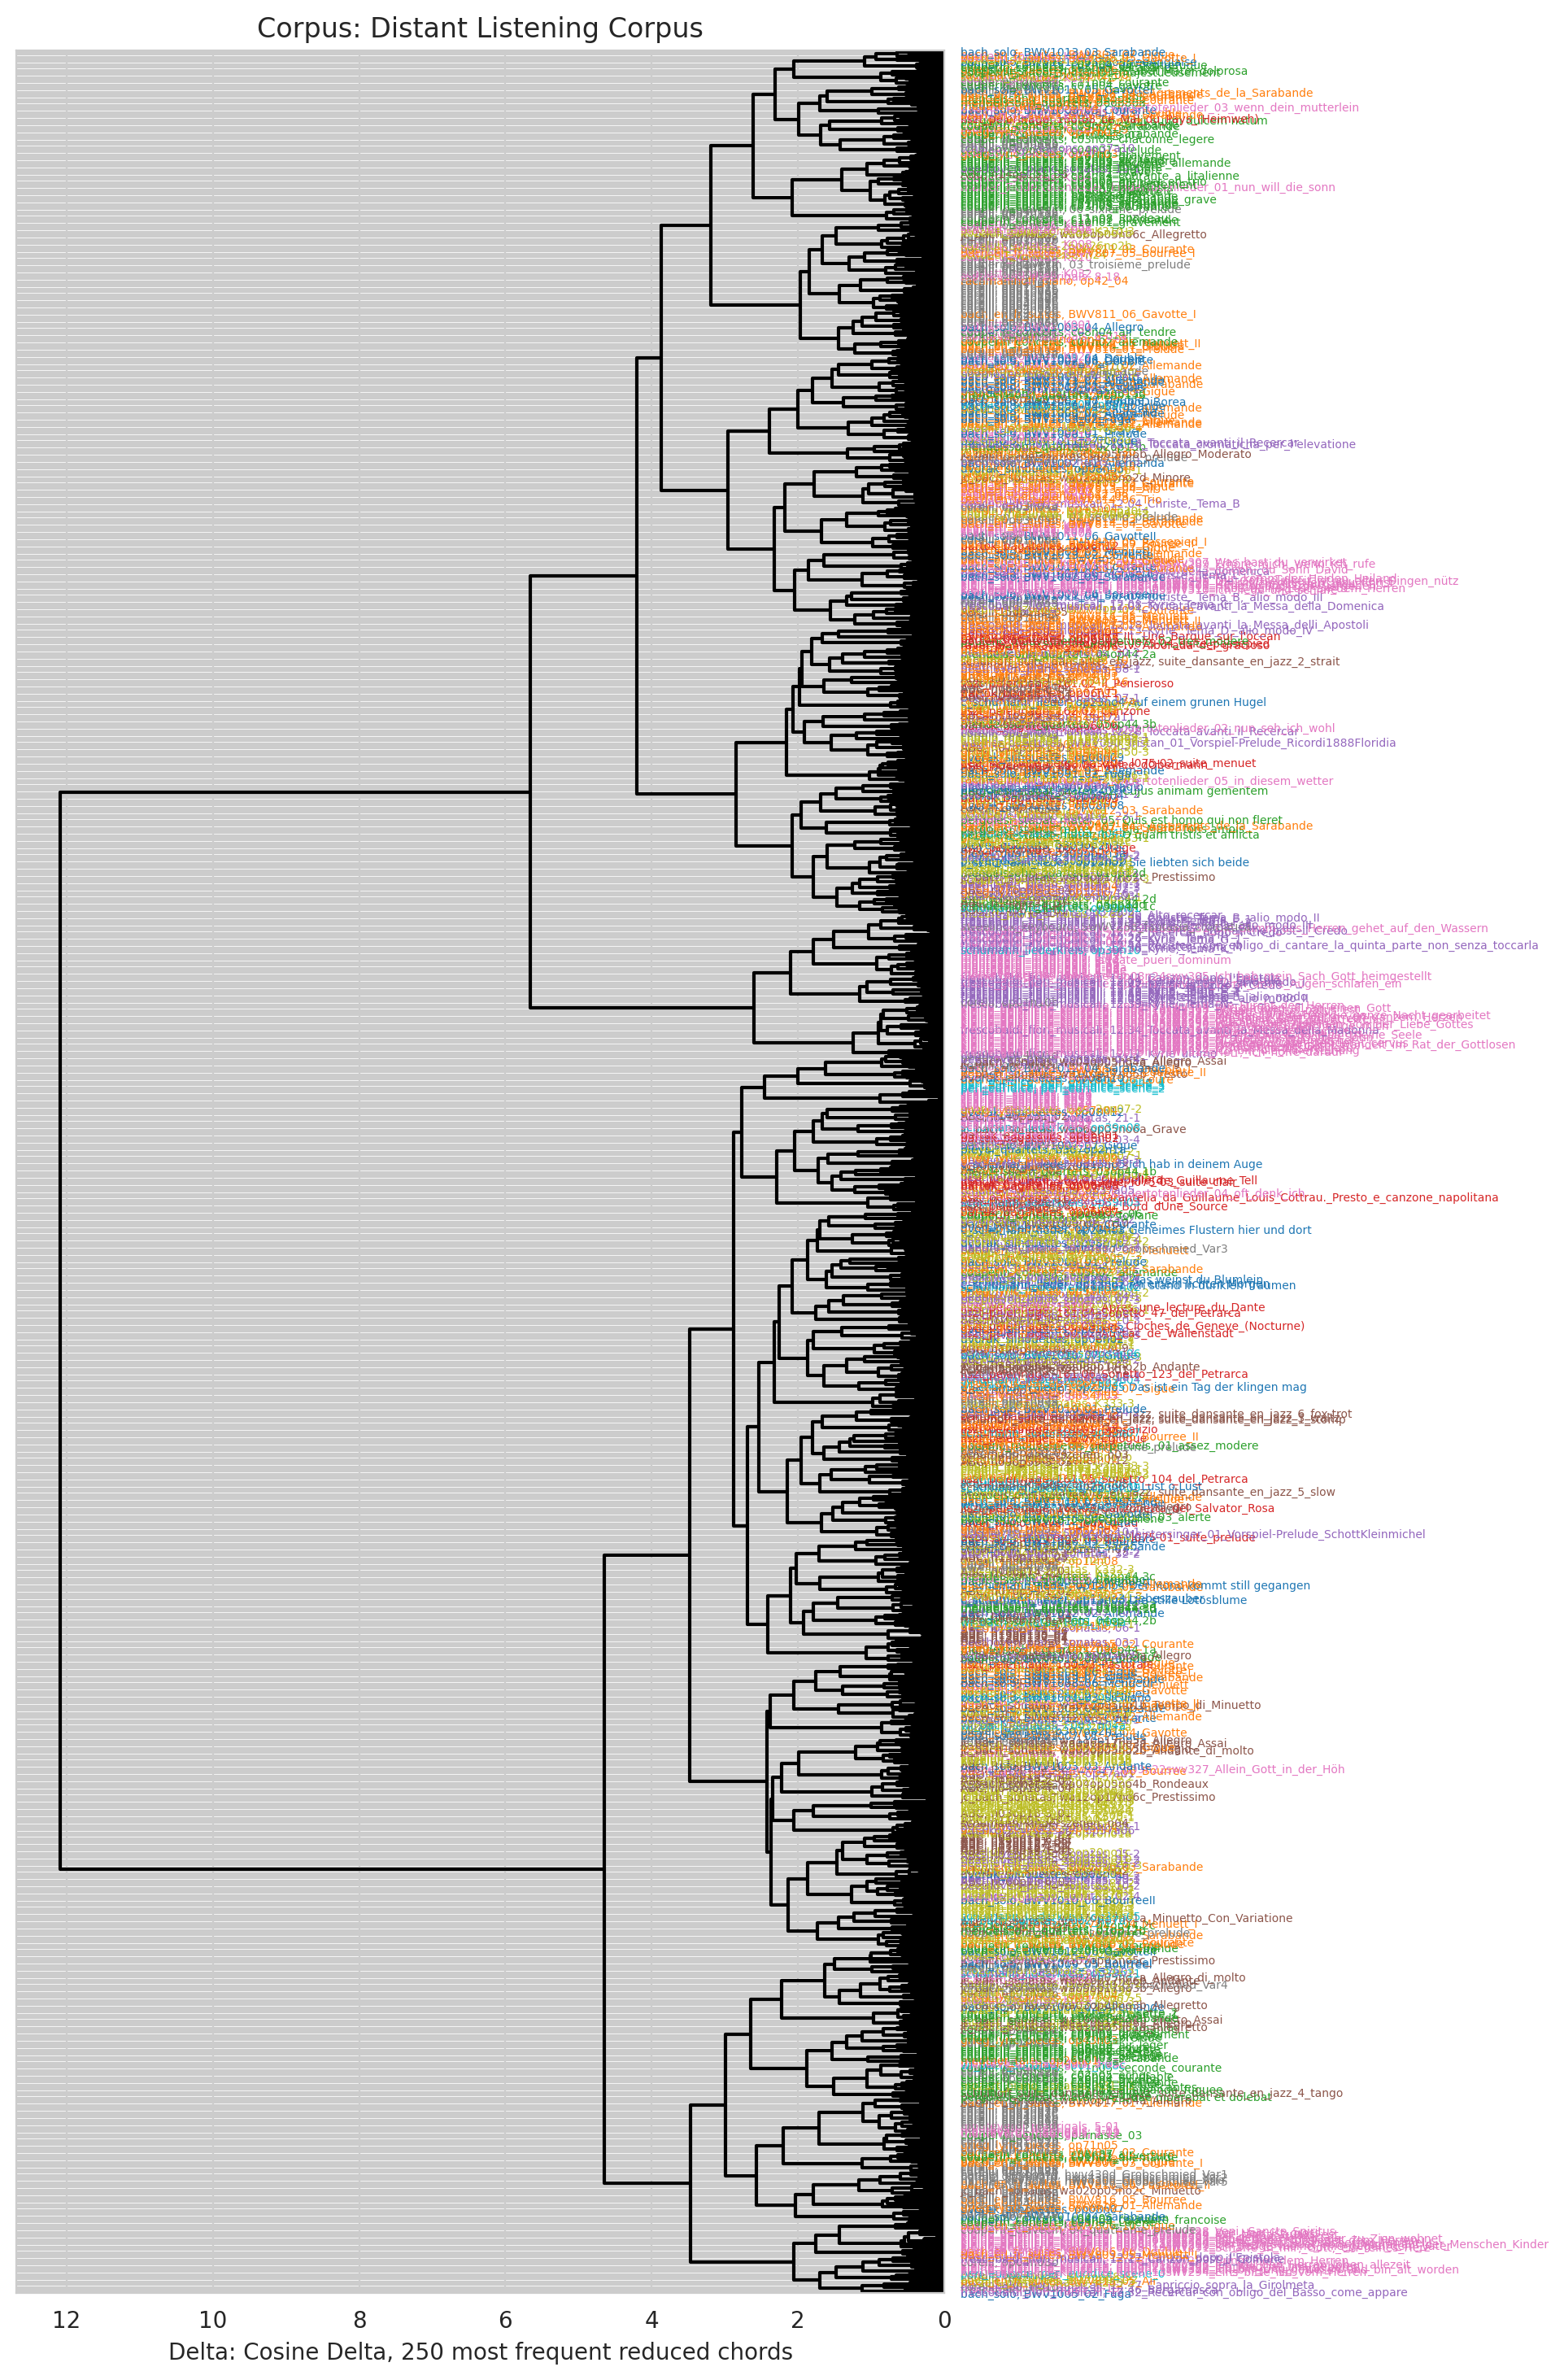

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,15))
delta.Dendrogram(clustering).show()

For any but a visual inspection, it is probably best to cut through the hierarchical clustering to provide flat clusters. This can be done with default settings from the hierarchical clustering:

In [14]:
type(clustering.distance_matrix)

delta.deltas.DistanceMatrix

In [15]:
clusters = clustering.fclustering()
print(clusters.describe())

39 clusters of 1219 documents (ground truth: 39 groups):
{1: ['bach_en_fr_suites, BWV806_06_Double_II',
     'bach_en_fr_suites, BWV806_10_Gigue',
     'bach_en_fr_suites, BWV809_05_Menuett_I',
     'bach_en_fr_suites, BWV815_05_Air', 'bach_solo, BWV1005_02_Fuga',
     'chopin_mazurkas, BI122op41-2', 'chopin_mazurkas, BI34op68-3',
     'corelli, op01n01d', 'corelli, op04n08b', 'corelli, op04n09d',
     'couperin_clavecin, 04_quatrieme_prelude',
     'frescobaldi_fiori_musicali, 12.17_Canzon_post_il_Comune',
     "frescobaldi_fiori_musicali, 12.27_Canzon_dopo_l'Epistola",
     'frescobaldi_fiori_musicali, '
     '12.32_Recercar_con_obligo_del_Basso_come_appare',
     'frescobaldi_fiori_musicali, 12.46_Bergamasca',
     'frescobaldi_fiori_musicali, 12.47_Capriccio_sopra_la_Girolmeta',
     'kleine_geistliche_konzerte, op08n02swv283_Bringt_her_dem_Herren',
     'kleine_geistliche_konzerte, op08n05swv286_Der_Herr_ist_gross',
     'kleine_geistliche_konzerte, '
     'op08n07swv288_Ihr_Heili

There are also some measures of cluster quality built into [our class](delta.rst#cluster.FlatClustering):

In [16]:
clusters.evaluate()

Cluster Errors         372.000000
Adjusted Rand Index      0.108865
Homogeneity              0.369928
Completeness             0.338655
V Measure                0.353602
Purity                   0.336341
Entropy                  0.549921
dtype: float64